In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/sample_data
!unzip -qq "/content/drive/MyDrive/AI 프로젝트/New Plant Diseases Dataset(Augmented).zip"
!unzip -qq "/content/drive/MyDrive/AI 프로젝트/test.zip"

/content/sample_data
replace __MACOSX/._New Plant Diseases Dataset(Augmented)? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

from keras.preprocessing.image import flow_from_directory # 이미지 업도르에 사용
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 처리에 사용
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2, # 층밀리기
                                   zoom_range=0.2, # 무작위 줌
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 128
train_gen = train_datagen.flow_from_directory(directory="/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         target_size=(256, 256),class_mode='categorical')

valid_gen= valid_datagen.flow_from_directory(directory="/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                         target_size=(256, 256),class_mode='categorical')


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
class_dict = train_gen.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
li = list(class_dict.keys())

In [ ]:
# 모델 생성
model = keras.Sequential()
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))

# 특징 추출 층
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))

model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))

model.add(keras.layers.Flatten())

# 분류 층
model.add(keras.layers.Dense(1568,activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38,activation="softmax"))

In [ ]:
#옵티마이져
opt = keras.optimizers.Adam(learning_rate=0.0001)
#컴파일
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 85, 85, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 85, 85, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                  

In [ ]:
train_num = train_gen.samples
valid_num = valid_gen.samples

In [ ]:
# 학습 과정에서 조기 종료를 할 수 있도록 설정

checkpoint_filepath = "FMbest.hdf5"

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1) # val loss가 5번 이상 같으면 존료

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [ ]:
# 학습
history = model.fit_generator(train_gen,
                         validation_data=valid_gen,
                         epochs=20,callbacks=[early_stop, save_best]
                         )

Epoch 1/20
2197/2197 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9767
Epoch 1: val_loss improved from inf to 0.11087, saving model to FMbest.hdf5
2197/2197 [==============================] - 1017s 463ms/step - loss: 0.0738 - accuracy: 0.9767 - val_loss: 0.1109 - val_accuracy: 0.9685
Epoch 2/20
2197/2197 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9797
Epoch 2: val_loss improved from 0.11087 to 0.06411, saving model to FMbest.hdf5
2197/2197 [==============================] - 1015s 462ms/step - loss: 0.0659 - accuracy: 0.9797 - val_loss: 0.0641 - val_accuracy: 0.9796
Epoch 3/20
2197/2197 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9802
Epoch 3: val_loss did not improve from 0.06411
2197/2197 [==============================] - 1016s 462ms/step - loss: 0.0619 - accuracy: 0.9802 - val_loss: 0.1528 - val_accuracy: 0.9603
Epoch 4/20
2197/2197 [==============================] - ETA: 0s - loss: 0.0591 - accuracy

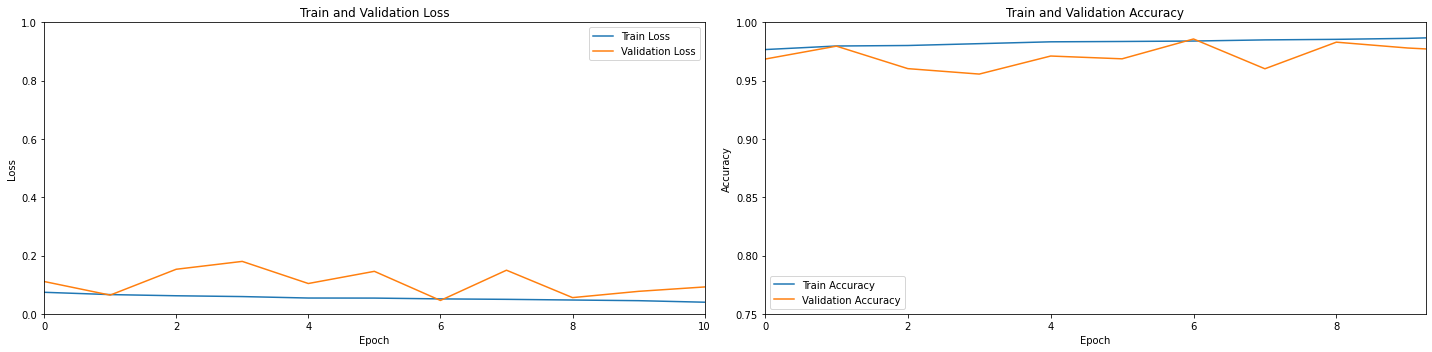

In [ ]:
# 모델 검증

# 학습 데이터 검증 데이터  loss 값 비교
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()
#학습 데이터 검증 데이터 정확도 비교
plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
# 모델 평가하기

print("-- Evaluate --")
scores = model.evaluate_generator(valid_gen, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 97.50%


In [ ]:
#model 저장
model.save('Plant_Desease_Prediction')

INFO:tensorflow:Assets written to: Plant_Desease_Prediction/assets


INFO:tensorflow:Assets written to: Plant_Desease_Prediction/assets


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tensorflow as tf
import keras

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TensorFlow version :  2.8.2
Keras version :  2.8.0


In [ ]:
# 모델 불러오기

from keras.models import load_model
model = load_model('Plant_Desease_Prediction')

In [ ]:
# class 에 따라 질병에 관한 정보 알려주는 함수


def solution(class_name):
  if 'healthy' in class_name:
    print('Healthy Plants')
  elif class_name == "Apple___Apple_scab":
    sol= 'https://www.independenttree.com/apple-scab-identification-prevention-treatment-2/'
    print('APPLE SCAB:',sol)
  elif class_name == "Apple___Black_rot":
    sol= 'https://extension.umn.edu/plant-diseases/black-rot-apple'
    print('Apple___Black_rot:',sol)
  elif class_name == "Apple___Cedar_apple_rust":
    sol= 'https://www.planetnatural.com/pest-problem-solver/plant-disease/cedar-apple-rust/'
    print('Apple___Cedar_apple_rust:',sol)
  elif class_name == "Cherry_(including_sour)___Powdery_mildew":
    sol= 'https://www.canr.msu.edu/news/controlling_powdery_mildew_in_tart_cherry_orchards'
    print('Cherry_(including_sour)___Powdery_mildew:',sol)
  elif class_name == "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot":
    sol= 'https://agrilifeextension.tamu.edu/library/landscaping/cercospora-leaf-spot-of-roses/'
    print('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:',sol)
  elif class_name == "Corn_(maize)__Common_rust":
    sol= 'https://cals.cornell.edu/field-crops/corn/diseases-corn/common-rust'
    print('Corn_(maize)__Common_rust:',sol)
  elif class_name == "Corn_(maize)___Northern_Leaf_Blight":
    sol= 'https://www.gardeningknowhow.com/edible/vegetables/corn/northern-corn-leaf-blight-control.htm'
    print('Corn_(maize)___Northern_Leaf_Blight:',sol)
  elif class_name == "Grape___Black_rot":
    sol= 'https://agrilifeextension.tamu.edu/library/landscaping/cercospora-leaf-spot-of-roses/'
    print('Grape___Black_rot:',sol)
  elif class_name == "Grape___Esca_(Black_Measles)":
    sol= 'https://www2.ipm.ucanr.edu/agriculture/grape/Eutypa-Dieback/'
    print('Grape___Esca_(Black_Measles):',sol)
  elif class_name == "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)":
    sol= 'https://www.goodfruit.com/11-tips-to-beat-grape-fungal-diseases/'
    print('Grape___Leaf_blight_(Isariopsis_Leaf_Spot):',sol)
  elif class_name == "Orange___Haunglongbing_(Citrus_greening)":
    sol= 'https://www2.ipm.ucanr.edu/agriculture/citrus/Huanglongbing/'
    print('Orange___Haunglongbing_(Citrus_greening):',sol)
  elif class_name == "Peach___Bacterial_spot":
    sol= 'https://www.canr.msu.edu/news/management_of_bacterial_spot_on_peaches_and_nectarines'
    print('Peach___Bacterial_spot:',sol)
  elif class_name == "Pepper,_bell___Bacterial_spot":
    sol= 'https://extension.wvu.edu/lawn-gardening-pests/plant-disease/fruit-vegetable-diseases/bacterial-leaf-spot-of-pepper'
    print('Pepper,_bell___Bacterial_spot:',sol)
  elif class_name == "Potato___Early_blight":
    sol= 'https://extension.wvu.edu/lawn-gardening-pests/plant-disease/fruit-vegetable-diseases/bacterial-leaf-spot-of-pepper'
    print('Potato___Early_blight:',sol)
  else:
    print("unhealthy & no information")


  

  

Following is our prediction:


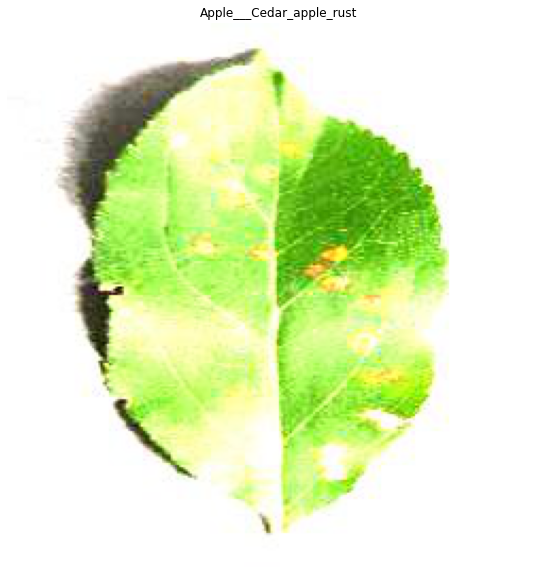


Apple___Cedar_apple_rust: https://www.planetnatural.com/pest-problem-solver/plant-disease/cedar-apple-rust/


In [ ]:
# 테스트
from keras.preprocessing import image
import numpy as np
image_path = "/content/sample_data/test/test/AppleCedarRust1.JPG"
new_img = image.load_img(image_path, target_size=(256, 256))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]


plt.figure(figsize = (10,10))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()
print()
solution(class_name)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)



Following is our prediction:


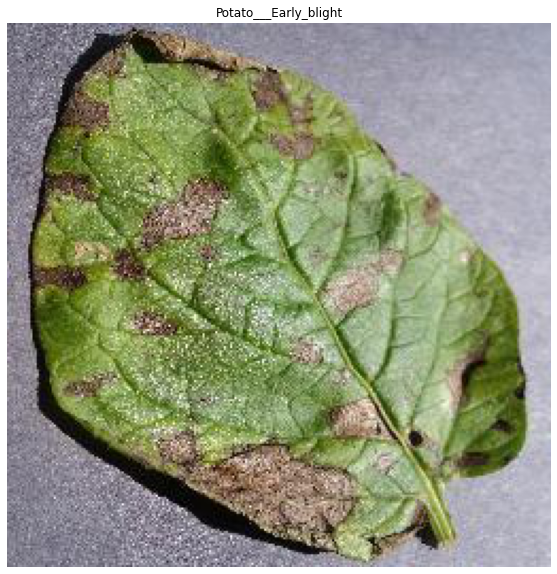


Potato___Early_blight: https://extension.wvu.edu/lawn-gardening-pests/plant-disease/fruit-vegetable-diseases/bacterial-leaf-spot-of-pepper


In [ ]:
image_path = "/content/sample_data/test/test/PotatoEarlyBlight1.JPG"
new_img = image.load_img(image_path, target_size=(256, 256))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]


plt.figure(figsize = (10,10))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()
print()
solution(class_name)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)